# Reproduce the Ikonomi 2020 model

>Ikonomi N, Kühlwein SD, Schwab JD, Kestler HA. Awakening the HSC: Dynamic Modeling of HSC Maintenance Unravels Regulation of the TP53 Pathway and Quiescence. Front Physiol. 2020 Jul 31;11:848. doi: 10.3389/fphys.2020.00848. PMID: 32848827; PMCID: PMC7411231.

**Goal:**
   
To unravel new mechanistic insights in the maintenance of hematopoietic stem cell quiescence, with particular attention to TP53 regulation.
  
**Knowledge source:**
  
Literature review

**Representation:**
  
Boolean network
Codes available at supplementary and https://github.com/sysbio-bioinf/HSC-boolean-network-model  

**Tools:**
  
The java framework ViSiBooL was used for modeling
The analysis of the dynamic behavior of the HSC model was performed by synchronous updates with the R package BoolNet
  

**in silico validation:**
  
They tested the regulatory model by assessing its ability to recapitulate different knockout conditions, and showed that the model could recapitulate the phenotype of published mouse models. 

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

home = "persistent/" # home path for Logic Model Merger
model_name = "Ikonomi2020"
txt_file = home + "LogicModelMerger/Models/" + model_name + ".txt"
sbml_file = home + "LogicModelMerger/Models/" + model_name + ".sbml"

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

## Regulatory graph visualization with GINsim

The model is downloaded from the [Biodivine Boolean Models (BBM) Benchmark Dataset](https://github.com/sybila/biodivine-boolean-models/tree/main/models/%5Bid-100%5D__%5Bvar-18%5D__%5Bin-3%5D__%5BACUTE-MYELOID-LEUKEMIA%5D),which is taken directly from the text in the paper.

First visualize the network model.   
 

In [22]:
ikonomi = biolqm.load(sbml_file)
ikonomi_lrg = biolqm.to_ginsim(ikonomi)
ginsim.show(ikonomi_lrg)

## Boolean network simulations of the model

As described in the paper:  
>First, we exhaustively simulated our model, obtaining four single state attractors. The network contains two external inputs (external quiescence and external cycling), resulting in four possible combinations. In accordance, each reached attractor shows a different combination of these nodes (Figure 2).

![Figure 2](figure2.jpeg)  
(Green indicates active nodes, blue indicates inactive ones.)  
  
We are going to reproduce these results.

### Experiment set-up
According to the paper, we are going to set up the simulations on `External quiescence` and `External cycling`.

In [4]:
# set the fix value for the simulations
lt = biolqm.perturbation(ikonomi, "External_quiescence%1 External_cycling%0")
st = biolqm.perturbation(ikonomi, "External_quiescence%1 External_cycling%1")
cyc = biolqm.perturbation(ikonomi, "External_quiescence%0 External_cycling%1")
un = biolqm.perturbation(ikonomi, "External_quiescence%0 External_cycling%0")

### Stable states calculation

In [7]:
# get the stable states
networks = [lt,st,cyc,un]
results = pd.DataFrame()
for network in networks:
    fps = biolqm.fixpoints(network)
    results = pd.concat([results, pd.DataFrame(fps)],ignore_index=True)
results.index = ["LT-HSC","ST-HSC","Cycling HSC","Unstimulated"]
results.T

,LT-HSC,ST-HSC,Cycling HSC,Unstimulated
External_quiescence,1,1,0,0
External_cycling,0,1,1,0
PIK3CA,0,1,1,0
TSC1,1,0,0,1
MTOR,0,1,1,0
FOXO3,1,0,0,0
ATM,1,0,0,0
ROS1,0,1,1,1
Mitochondria,0,1,1,0
Autophagy,0,0,0,0


The results are identical.

## The asynchronous stable states

In [48]:
net = boolnet.loadNetwork(txt_file)
attr = boolnet.getAttractors(net)
print(attr)

Attractor 1 is a simple attractor consisting of 1 state(s):

 |--<-----------------------------------|
 V                                      |
 100101100000010010111111000000000000   |
 V                                      |
 |-->-----------------------------------|


Genes are encoded in the following order: EXTERNAL_QUIESCENCE EXTERNAL_CYCLING PIK3CA TSC1 MTOR FOXO3 ATM ROS1 MITOCHONDRIA AUTOPHAGY NRAS ETS1 MEFV GSK3B CTNNB1 MYC BMI1 MDM2 TP53 CDKN1C CDKN1A CDKN1B GFI1 RB1 E2F1 CCND1 CCNE1 S_PHASE AKT1 CDKN2D CDKN2A PRO_APOPTOTIC_PROTEINS ANTI_APOPTOTIC_PROTEINS CYCS APOPTOSIS SENESCENCE

Attractor 2 is a simple attractor consisting of 1 state(s):

 |--<-----------------------------------|
 V                                      |
 011010011010101111000000111110001000   |
 V                                      |
 |-->-----------------------------------|


Genes are encoded in the following order: EXTERNAL_QUIESCENCE EXTERNAL_CYCLING PIK3CA TSC1 MTOR FOXO3 ATM ROS1 MITOCHONDRIA A

In [49]:
# Activate the conversion context to use pandas DataFrame
pandas2ri.activate()

# Access the dataframe stored under the key '1'
attrr = boolnet.plotAttractors(attr)
r_df = attrr.rx2('1')

# Use the local converter context to manage the conversion to a numpy array
with localconverter(robjects.default_converter + pandas2ri.converter):
    np_array = np.array(r_df)

# Extract names from the R dataframe
row_names = list(r_df.rownames)
column_names = list(r_df.colnames)

# Create a pandas DataFrame from the numpy array
df = pd.DataFrame(np_array, index=row_names, columns=column_names)

df = df.T
df.index = df.index.str.replace('Attr', 'S')
df.to_csv(home + 'LogicModelMerger/SimulationResults/attr_' + model_name + '.csv')
df

,EXTERNAL_QUIESCENCE,EXTERNAL_CYCLING,PIK3CA,TSC1,MTOR,FOXO3,ATM,ROS1,MITOCHONDRIA,AUTOPHAGY,NRAS,ETS1,MEFV,GSK3B,CTNNB1,MYC,BMI1,MDM2,TP53,CDKN1C,CDKN1A,CDKN1B,GFI1,RB1,E2F1,CCND1,CCNE1,S_PHASE,AKT1,CDKN2D,CDKN2A,PRO_APOPTOTIC_PROTEINS,ANTI_APOPTOTIC_PROTEINS,CYCS,APOPTOSIS,SENESCENCE
S1.1,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
S2.1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,0
S3.1,1,1,1,0,1,0,0,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
S4.1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1,1,1


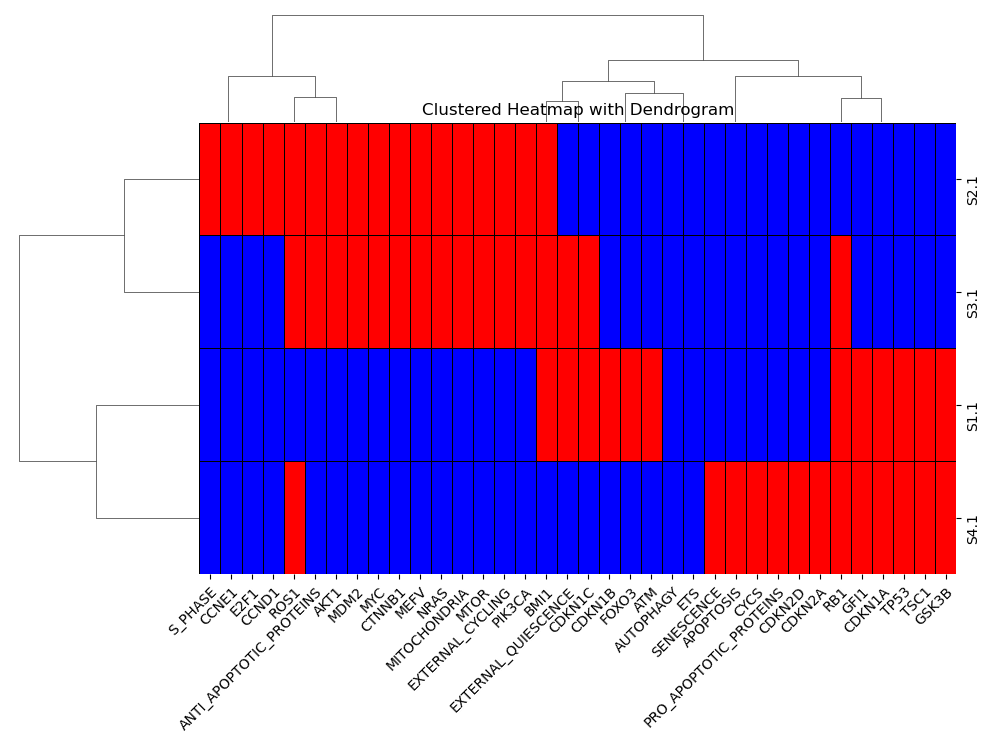

In [16]:
# Clustering
cmap = ListedColormap(['blue', 'red'])

g = sns.clustermap(df, method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(10, 8), cbar=False, col_cluster=True)
g.ax_heatmap.set_title('Clustered Heatmap with Dendrogram')
g.ax_heatmap.tick_params(axis='y', labelsize=10)  # Adjust y-tick label size if needed
g.ax_heatmap.tick_params(axis='x', labelsize=10)  # Adjust x-tick label size if needed, rotate if necessary
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels for better readability

# Hide the color bar space if it's not needed
g.cax.set_visible(False)

plt.show()

**The Ikonomi et al. results are reproducible.**   